# TGS Salt Identification

## 1. Bisness Problem

### 1.1 Descrption

Several areas of Earth with large accumulations of oil and gas also have huge deposits of salt below the surface.

But unfortunately, knowing where large salt deposits are precisely is very difficult. Professional seismic imaging still requires expert human interpretation of salt bodies. This leads to very subjective, highly variable renderings. More alarmingly, it leads to potentially dangerous situations for oil and gas company drillers.

To create the most accurate seismic images and 3D renderings, TGS (the world’s leading geoscience data company) is hoping Kaggle’s machine learning community will be able to build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

## 1.2 Data

The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

### 1.3 Problem Statement

Here we have to correctly segment slat and sediment regions

### 1.4 Source/Useful Links

#### 1.4.1 Source

**Source : https://www.kaggle.com/c/tgs-salt-identification-challenge**

1.4.1 Useful Links

Reference : https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics

## 2. Machine Learning Problem Formulation

### 2.1. Type of machine learning problem

**This is a image segmentation problem. Here we will take input image and generate a output image in which each pixel can be either 0 or 255 i.e sedimet or salt**

### 2.2. Performence Metric

**IOU Metric**

This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:
IoU(A,B)=A∩BA∪B.

The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.

At each threshold value t, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:
TP(t)/(TP(t)+FP(t)+FN(t)).

A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold: 
      (1/thresholds)(∑tTP(t)/TP(t)+FP(t)+FN(t)).

Lastly, the score returned by the competition metric is the mean taken over the individual average precisions of each image in the test dataset.

## 3 Data Preparation

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'tgs_salt/'

Mounted at /content/gdrive


In [0]:
import zipfile
with zipfile.ZipFile(base_dir + 'data.zip', 'r') as myzip:
    myzip.extractall()

In [0]:
PATH = './data'
TRAIN_IMG = PATH + '/train/images/'
TRAIN_MASKS = PATH + '/train/masks/'
TEST_IMG = PATH + '/test/images/'

In [0]:
%tensorflow_version 1.x

In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import random

import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import cv2
from skimage.transform import resize


import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Lambda, Conv2DTranspose, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.layers import *

from keras.models import load_model
from keras.utils import np_utils

from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

from keras import backend as K

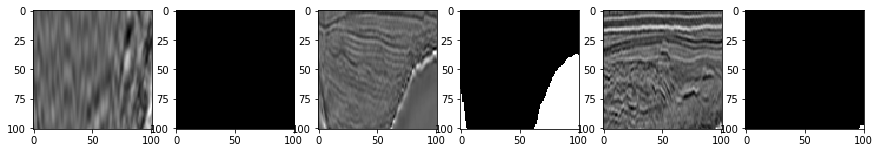

In [0]:
# Plotting some input: output pair images
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = cv2.imread(TRAIN_IMG + img_name + '.png')
    
    img_mask = cv2.imread(TRAIN_MASKS + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [0]:
train_ids = os.listdir(TRAIN_IMG)
test_ids = os.listdir(TEST_IMG)

In [0]:
train_ids[0]

'7d0cea3489.png'

In [0]:
image_size = (128, 128, 3)
# This function takes input file names and generate train data
def generate_train_dataset(files, image_size):
  X_train = []
  Y_train = []
  for n, id_ in enumerate(files):
    img = np.float32(cv2.resize(cv2.imread(TRAIN_IMG + id_, 1), (128, 128))) / 255.0
    # img = img.reshape(128, 128, 1)
    X_train.append(img)
    mask = np.float32(cv2.resize(cv2.imread(TRAIN_MASKS + id_, 0), (128, 128) )) / 255.0
    mask = mask.reshape(128, 128, 1)
    Y_train.append(mask)
  return np.asarray(X_train), np.asarray(Y_train)
# This function takes input file names and generate test data
def generate_test_dataset(files, image_size):
  X_test = []
  for n, id_ in enumerate(files):
    img = np.float32(cv2.resize(cv2.imread(TEST_IMG + id_, 1), (128, 128))) / 255.0
    X_test.append(img)
  return np.asarray(X_test)

X_train, Y_train = generate_train_dataset(train_ids, image_size)
image_size = X_train[0].shape

In [0]:
print("X_train data size :", X_train.shape)
print("Y_train data size :", Y_train.shape)

X_train data size : (4000, 128, 128, 3)
Y_train data size : (4000, 128, 128, 1)


3388


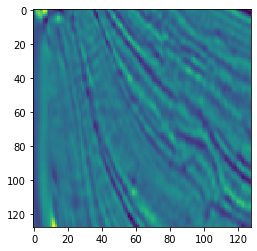

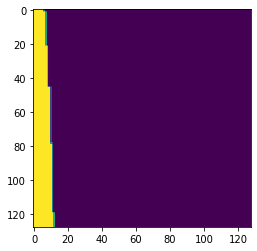

In [0]:
ix = random.randint(0, len(train_ids))
print(ix)
plt.imshow(X_train[ix])
plt.show()
# tmp = np.squeeze(Y_train[ix]).astype(np.float32)
# plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.imshow(Y_train[ix].reshape(128, 128))
plt.show()

In [0]:
# Ref : https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
# Build U-Net model
inputs = Input(image_size)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 128, 128, 8)  224         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_212 (Conv2D)             (None, 128, 128, 8)  584         conv2d_211[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_49 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_212[0][0]                 
___________________________________________________________________________________________

In [0]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=30, 
                    callbacks=[earlystopper, checkpointer])


Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 17s 5ms/step - loss: 0.5462 - mean_iou: 0.3805 - val_loss: 0.5272 - val_mean_iou: 0.3789

Epoch 00001: val_loss improved from inf to 0.52718, saving model to model-tgs-salt-1.h5
Epoch 2/30
3600/3600 [==============================] - 8s 2ms/step - loss: 0.4059 - mean_iou: 0.4027 - val_loss: 0.4263 - val_mean_iou: 0.4386

Epoch 00002: val_loss improved from 0.52718 to 0.42634, saving model to model-tgs-salt-1.h5
Epoch 3/30
3600/3600 [==============================] - 8s 2ms/step - loss: 0.3373 - mean_iou: 0.4688 - val_loss: 0.3452 - val_mean_iou: 0.4945

Epoch 00003: val_loss improved from 0.42634 to 0.34521, saving model to model-tgs-salt-1.h5
Epoch 4/30
3600/3600 [==============================] - 8s 2ms/step - loss: 0.3061 - mean_iou: 0.5156 - val_loss: 0.3504 - val_mean_iou: 0.5344

Epoch 00004: val_loss did not improve from 0.34521
Epoch 5/30
3600/3600 [===========================

In [0]:
model.save(base_dir + "model_tgs_salt_1.h5")

In [0]:
model = load_model("model-tgs-salt-1.h5", custom_objects={"mean_iou": mean_iou})

In [0]:
# Get and resize test images
X_test = generate_test_dataset(test_ids, image_size)
print("Test data size : ", X_test.shape)

Test data size :  (18000, 128, 128, 3)


In [0]:
# Predict on train, val and test
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - 7s 386us/step


In [0]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(cv2.resize(preds_test[i], (101, 101)))

In [0]:
preds_test_upsampled[0].shape


(101, 101)

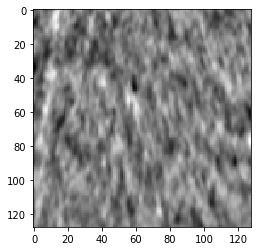

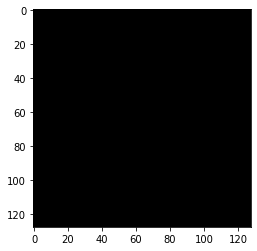

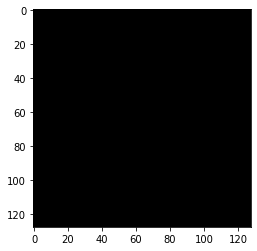

In [0]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(X_train[ix])
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

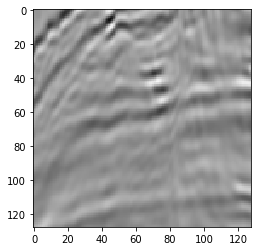

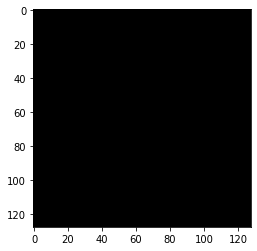

In [0]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
plt.imshow(X_test[ix])
plt.show()
# tmp = np.squeeze(Y_train[ix]).astype(np.float32)
# plt.imshow(np.dstack((tmp,tmp,tmp)))
# plt.show()
tmp = np.squeeze(preds_test_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [0]:
# Ref : https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in enumerate(test_ids)}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(base_dir + 'submission.csv')

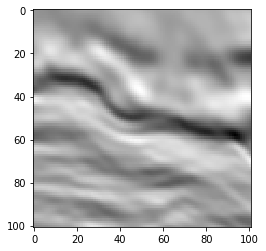

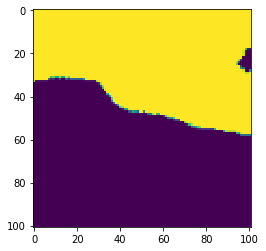

In [0]:
ix = random.randint(0, len(test_ids))
def model_predict(img_path, model):
  X_test = generate_test_dataset([img_path], image_size)

  preds_test = model.predict(X_test)
  preds_test_t = (preds_test > 0.5).astype(np.uint8)
  return cv2.resize(preds_test_t[0] * 255, (101, 101))

plt.imshow(cv2.imread(TEST_IMG + test_ids[ix], 1))
plt.show()
plt.imshow(model_predict(test_ids[ix], model))
plt.show()
    